# Classification Metrics and Validation Techniques

This worksheet builds uses the k-fold validation technique to determine the hyperparameter required for Ridge Regression.

In [259]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Basic Accuracy Check on Data

In [388]:
df = pd.read_csv('../Data/spambase_2.csv',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [5]:
df.shape

(2837, 58)

In [25]:
# Covnert X,y to numpy arrays
X = df.iloc[:,0:57].values
y = df.iloc[:,57].values

In [28]:
# Fit Data using logistic regression
lr = LogisticRegression(solver='liblinear')
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
# Make predictions and check accuracy
ypred = lr.predict(X)
print("Accuracy =", accuracy_score(y,ypred))

confusion_matrix(y,ypred)


Accuracy = 0.9837856891082128


array([[2783,    4],
       [  42,    8]], dtype=int64)

# Implement K-Fold Validation with L2 Regularization

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv('../Data/spambase.csv',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
# Convert X,y to numpy arrays
X = df.iloc[:,0:57].values
y = df.iloc[:,57].values.reshape(-1,1)

n = y.shape[0]

# Ridge Regression Class

Reminder: Ridge Regression implements regularization by adding to the Loss function:

$$ Loss \rightarrow Loss + \lambda |\theta|^2 $$

In [15]:
class LogisticRegression():
    
    def __init__(self):
        
        self.theta = []
        self.scaler = StandardScaler()
        
    def sigmoid(self,X):
        
        linear_form = X@self.theta
        h = 1/(1+np.exp(-linear_form))
        return h
    
    def negative_loglikelihood(self,X,y):
        
        n = y.shape[0]
        h = self.sigmoid(X)
        if any(h>0.999):
            idx_high = np.where(h>0.999)[0]
            h[idx_high] = 0.999
        elif any(h<0.001):
            idx_low = np.where(h<0.001)[0]
            h[idx_low] = 0.001
        J = -(1/n)*(np.sum(y*np.log(h)) + np.sum((1-y)*np.log(1-h)))

        return J

    def gradient(self,X,y,lmbda):

        n = y.shape[0]
        h = self.sigmoid(X)
        dtheta = (1/n)*X.T@(h-y)+(lmbda/n)*self.theta

        return dtheta
    
    def fit(self,x_train,y_train,x_test,y_test,max_iter,lmbda,learning_rate,plot_flag = True):
        
        # Number of examples, parameters
        n_train = y_train.shape[0]
        n_test = y_test.shape[0]
        n_params = x_train.shape[1]
        
        # Scale the data according to training data
        x_train = self.scaler.fit_transform(x_train)
        x_test = self.scaler.transform(x_test)
        
        # Add column of ones to x data
        x_train = np.c_[np.ones(n_train),x_train]
        x_test = np.c_[np.ones(n_test), x_test]
        
        # Initialize theta
        self.theta = np.random.uniform(low=-0.1,high=0.1, size=(n_params+1,1))
        
        # Initialize cost vector and iteration vector for later plotting
        iter_vec = np.array(range(max_iter))
        cost_vec_train = np.arange(max_iter).astype('float')
        cost_vec_test = np.arange(max_iter).astype('float')

        for ii in range(max_iter):

            # Calculate the gradient
            dtheta = self.gradient(x_train,y_train,lmbda)

            # Update theta
            self.theta = self.theta - learning_rate * dtheta

            # Calculate the value of the log-likelihood
            cost_train = self.negative_loglikelihood(x_train,y_train)
            cost_test = self.negative_loglikelihood(x_test,y_test)

            # Save cost for later plotting
            cost_vec_train[ii] = cost_train
            cost_vec_test[ii] = cost_test
            
        # Plot final solution
        if plot_flag:
            plt.plot(iter_vec,cost_vec_test,'-r',label='Test Error')
            plt.plot(iter_vec,cost_vec_train,'b',label='Train Error')
            plt.xlabel('Epoch')
            plt.ylabel('Log-Likelihood')
            plt.yscale('log')
            plt.title('lmbda = '+str(lmbda))
            plt.legend()
            plt.show()
    
    def predict(self,X,threshold):
        
        # Scale new data
        X = self.scaler.transform(X)
        
        # Add the column of ones
        X = np.c_[np.ones(X.shape[0]),X]
        
        # Transform to get new y
        linear_form = X@self.theta
        h = 1/(1+np.exp(-linear_form))
        
        # Prediction is 0s and 1s based on threshold
        ypred = np.array([int(hi>threshold) for hi in h]).reshape(-1,1)
        
        return ypred

In [16]:
model = LogisticRegression()

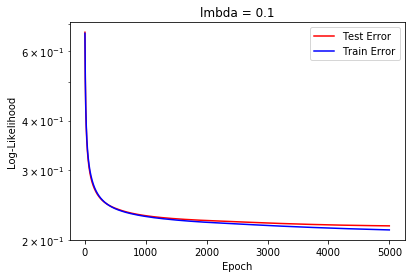

In [18]:
#Split Training Set and Testing Set
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.5)

model.fit(x_train,y_train,x_test,y_test,5000,0.1,1e-1)

In [287]:
ypred_train = model.predict(x_train,0.5)
ypred_test = model.predict(x_test,0.5)
print("Training Accuracy =", accuracy_score(y_train,ypred_train))
print("Test Accuracy =", accuracy_score(y_test,ypred_test))
confusion_matrix(y_train,ypred_train)
confusion_matrix(y_test,ypred_test)

Training Accuracy = 0.9182608695652174
Test Accuracy = 0.9096045197740112


array([[1307,   59],
       [ 149,  786]], dtype=int64)

## K-Folds Cross-Validation

This searches for the best hyperparameters by partitioning the data into K subsets, and then leaving out one subset to use as the test set. After iterating over all K subsets, the average accuracy is calculated to determine which hyperparameters were best. 

In [19]:
# Partition the data set into K-folds
k_folds = 5
n_data = y.shape[0]
n_partition = int(n_data/k_folds)

x_partitions = []
y_partitions = []

indices = np.arange(n_data)
for ii in range(k_folds):
    
    indices_permuted = np.random.permutation(indices)
    
    if ii==(k_folds-1):
        n_partition = len(indices_permuted)
        
    idx_partition = indices_permuted[0:n_partition]
    indices = indices_permuted[n_partition:]
    x_partitions.append(X[idx_partition])
    y_partitions.append(y[idx_partition])

In [20]:
# Fit lmbda using k-folds
lmbda_best = 0
lmbda_list = [0,0.001,0.01,0.1,1,10,100]

# Initialize model
model = LogisticRegression()

# Initialize an accuracy list for each k_fold
accuracy_list = np.arange(k_folds).astype('float')
accuracy_best = 0

# Loop through all the lmbda and fine the best one
for lmbda in lmbda_list:
    for jj in range(k_folds):

        # Create the training and validation data
        all_idx = list(range(k_folds))
        test_idx = jj
        all_idx.remove(jj)
        train_idx = all_idx

        x_test = x_partitions[test_idx]
        y_test = y_partitions[test_idx]

        x_train = x_partitions[train_idx[0]]
        y_train = y_partitions[train_idx[0]]
        for ii in train_idx[1::]:
            x_train = np.vstack((x_train,x_partitions[ii]))
            y_train = np.vstack((y_train,y_partitions[ii]))

        # Fit model
        model.fit(x_train,y_train,x_test,y_test,3000,lmbda,1e-1,False)
        
        # Make predictions
        ypred_test = model.predict(x_test,0.5)
        accuracy_kfold_j = accuracy_score(y_test,ypred_test)
        accuracy_list[jj] = accuracy_kfold_j

    # Average over all k folds    
    accuracy = np.mean(accuracy_list)
    
    # Update the best value of lmbda
    if accuracy>accuracy_best:
        lmbda_best = lmbda
        accuracy_best = accuracy

print("Best value of lmbda was: ",lmbda_best)
print("Accuracy: ",accuracy_best)

Best value of lmbda was:  0.1
Accuracy:  0.9237150073171883
